# Setup

This notebook is demonstrating how to use data from the Tycho Project stored in a local relational database 
(SQLite).


In [1]:
%%bash

# fetch Git repos if necessary
if [ ! -d project-tycho-utilities ]; then
  git clone https://github.com/lgautier/project-tycho-utilities.git; 
fi
cd project-tycho-utilities

Building an SQLite database is taken care of with one line:

In [2]:
! make all

make: Nothing to be done for 'all'.


In [3]:
%load_ext rpy2.ipython

# Accessing the tables from R

Access the SQLite tables from R's `dplyr` package: 

In [4]:
%%R

suppressMessages(library(dplyr))
dbfilename <- "tycho.db"
datasrc <- dplyr::src_sqlite(dbfilename)
disease_tbl <- dplyr::tbl(datasrc, "disease")
casecount_tbl <- dplyr::tbl(datasrc, "casecount")
location_tbl <- dplyr::tbl(datasrc, "location")

# Looking at the data...

## Measles

The data can be sparse for some locations and/or diseases. We focus on measles and select the states (state-level aggregates do not have an associated city) for which we have the largest number of cases:

In [5]:
%%R

library(magrittr)
# Get the locations (states only, that is locations for which
# the attribute "city" is missing) ordered by the largest number
# of recorded cases of MEASLES
res <- casecount_tbl %>%
  dplyr::inner_join(disease_tbl, by=c("disease_id"="id")) %>%
  dplyr::filter(name=="MEASLES") %>%
  dplyr::group_by(location_id, disease_id) %>%
  dplyr::summarize(sumcount=sum(count)) %>%
  dplyr::arrange( desc(sumcount))

top_locations <- res %>%
  dplyr::ungroup() %>%
  dplyr::inner_join(location_tbl, by=c("location_id"="id")) %>%
  dplyr::filter(is.na(city)) %>%
  head(20) %>%
  collect()

Now that we have these locations, we select all data available for them (and our disease of interest) using an inner join. We use a filter with `sumcount >=` because `dplyr` does not translate `head()` to SQL for SQLite databases.:

In [6]:
%%R

# Get the count data for the 20 locations with the largest number
# of cases
dataf <- res %>%
    dplyr::filter(sumcount >= top_locations$sumcount[20]) %>%
    dplyr::inner_join(casecount_tbl,
                      by=c("location_id"="location_id",
                       "disease_id"="disease_id"))

The hard part is (already) done. We only need to prepare our result table for plotting. In particular, we are joining that result table with the table that contain information about the location (otherwise we only have a location ID) and we create columns derived from the date (month, year, week number):

In [7]:
%%R

# prepare data.frame for plot
dataf_plot <- dataf %>%
    dplyr::inner_join(location_tbl, by=c("location_id"="id")) %>%
    dplyr::filter(is.na(city)) %>%
    dplyr::collect() %>%
    dplyr::mutate(date=as.POSIXct(strptime(date_from, format="%Y-%m-%d")),
                  month = format(date, "%m"),
                  year = format(date, "%Y"),
                  weeknum = as.numeric( format(date+3, "%U")))

The R package `ggplot2` is letting us build easy a figure that shows for each decade the week number on the x-axis and the number of recorded cases on the y-axis for our selected locations. Note the dip during the school vacation in the summer:

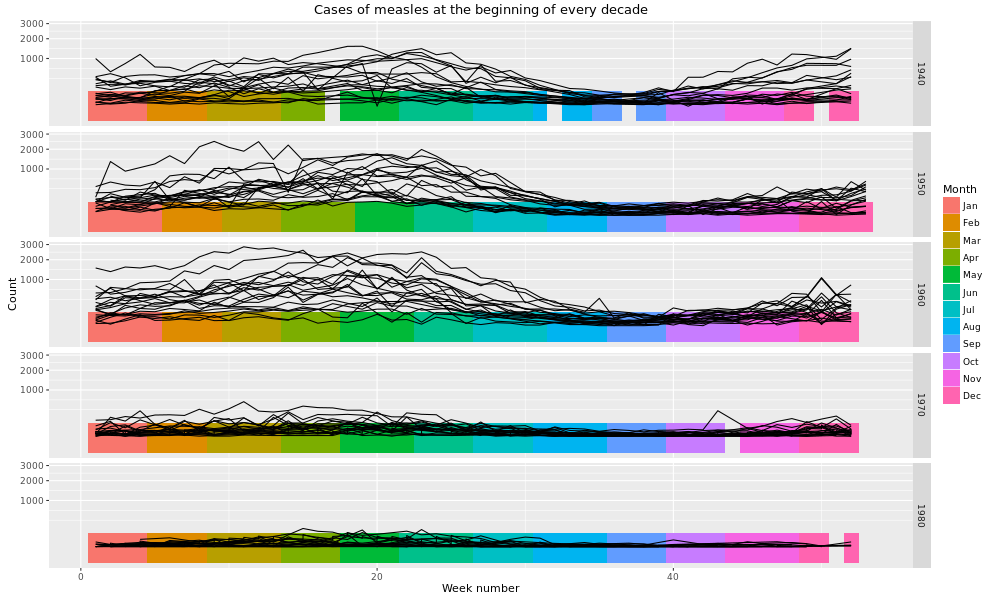

In [8]:
%%R -w 1000 -h 600 

# plot count every 10 years
suppressMessages(library(ggplot2))
p <- ggplot(dataf_plot %>% filter(year %in% seq(1940, 1980, by=10))) +
  geom_tile(aes(x=weeknum, y=0, fill=factor(month, ordered=TRUE)),
            height=20) +
  geom_line(aes(x=weeknum, y=count, group=location_id)) +
  scale_x_continuous("Week number") + 
  scale_y_sqrt("Count") +
  scale_fill_discrete("Month", labels=month.abb) +
  facet_grid(year~.) +
  ggtitle('Cases of measles at the beginning of every decade')
print(p)

The figure above it hinting at a dramatic drop in the number of cases between 1960 and 1970 for our states with the largest total number of cases. `dplyr` and `ggplot2` are making the creation of a visualization that can pinpoint more precisely when the drop is happening still relatively easy.

Since we want to plot data for each state in a panel, the year will be on the y-axis while the week number will remain on the x-axis, and the number of cases will be represented with colors.

One can observe that drop in the number of cases drops 2-3 years earlier in the state of NY compared to TX or PA. Whether this is the result of vaccination policies could be checked. one can also observer horizontal stripes suggesting a strong year-to-year term in the number of cases.

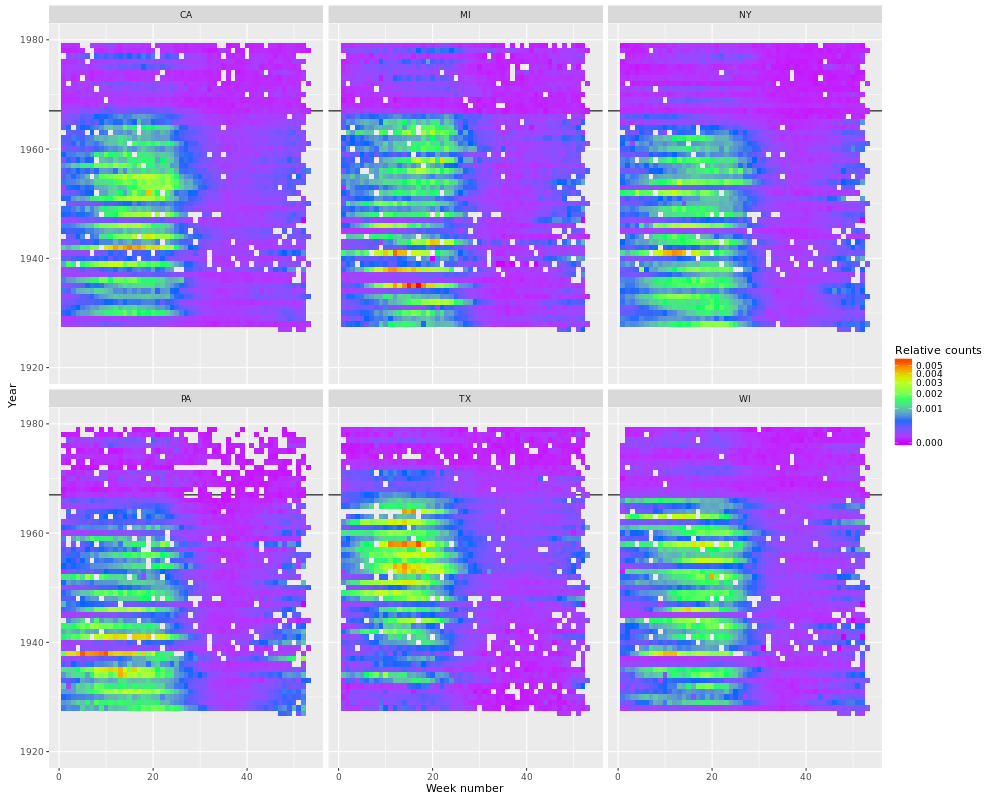

In [9]:
%%R -w 1000 -h 800

# select 6 locations with the largest total number of cases 
dataf <- res %>%
    dplyr::filter(sumcount >= top_locations$sumcount[6]) %>%
    dplyr::inner_join(casecount_tbl,
                      by=c("location_id"="location_id",
                       "disease_id"="disease_id"))

# prepare data.frame for plot
dataf_plot <- dataf %>%
    dplyr::inner_join(location_tbl, by=c("location_id"="id")) %>%
    dplyr::collect() %>%
    dplyr::mutate(date=as.POSIXct(strptime(date_from, format="%Y-%m-%d")),
                  month = format(date, "%m"),
                  year = format(date, "%Y"),
          weeknum = as.numeric( format(date+3, "%U")))

# plot counts for all years betweem 1920 and 1980 for the
# top 6 locations
p <- ggplot(dataf_plot %>%
        dplyr::filter(is.na(city))) +
  geom_hline(yintercept=1967) +
  geom_tile(aes(x=weeknum, y=as.integer(year), fill=count/sumcount)) +
  scale_fill_gradientn("Relative counts",
                       trans="sqrt", colors=rev(rainbow(5))) +
  scale_x_continuous("Week number") +
  scale_y_continuous("Year", limits=c(1920, 1980)) +
  facet_wrap(~state)
print(p)

# Parametrization

The nice things about structure data is that a lot of the data extraction and preparation for analysis or figures can be made parametric. We could explore whether similar patterns exist with other infectious diseases for which we have data by making the disease a parameter:

In [10]:
%%R


get_locations_with_most_cases <- function(disease, topn=6, state_level=TRUE) {
  res <- casecount_tbl %>%
    dplyr::inner_join(disease_tbl, by=c("disease_id"="id")) %>%
    dplyr::filter(name==disease) %>%
    dplyr::group_by(location_id, disease_id) %>%
    dplyr::summarize(sumcount=sum(count)) %>%
    dplyr::arrange( desc(sumcount))

    
  top_locations <- res %>%
    dplyr::ungroup() %>%
    dplyr::inner_join(location_tbl, by=c("location_id"="id"))
    
  if (state_level) {
    top_locations <- top_locations %>%
                     dplyr::filter(is.na(city))
  } else {
    top_locations <- top_locations %>%
                     dplyr::filter(!is.na(city))
  }
  top_locations <- top_locations %>%
                   head(topn) %>%
                   collect()
  list(sumcount=res, top_locations=top_locations)
}

build_dataf <- function(disease, topn=6, state_level=TRUE) {
    
  res <- get_locations_with_most_cases(disease, topn=topn, state_level=state_level)
    
  dataf <- res$sumcount %>%
    dplyr::filter(sumcount >= res$top_locations$sumcount[topn]) %>%
    dplyr::inner_join(casecount_tbl,
                      by=c("location_id"="location_id",
                           "disease_id"="disease_id"))
    
  # prepare data.frame for plot
  if (state_level) {
    dataf_pos <- dplyr::filter(location_tbl, is.na(city))  
  } else {
    dataf_pos <- dplyr::filter(location_tbl, !is.na(city))  
  }
  
    
  dataf_plot <- dataf %>%
      dplyr::inner_join(dataf_pos, by=c("location_id"="id")) %>%
      dplyr::collect() %>%
      dplyr::mutate(date=as.POSIXct(strptime(date_from, format="%Y-%m-%d")),
                    month = format(date, "%m"),
                    year = format(date, "%Y"),
                    weeknum = as.numeric( format(date+3, "%U")))

  dataf_plot
}

We have 50 diseases to choose from:

In [11]:
%%R

dplyr::select(disease_tbl, name) %>% head()

Source:   query [?? x 1]
Database: sqlite 3.8.6 [tycho.db]

                           name
                          <chr>
1 TYPHOID FEVER [ENTERIC FEVER]
2                 SCARLET FEVER
3                    DIPHTHERIA
4    WHOOPING COUGH [PERTUSSIS]
5                  TYPHUS FEVER
6                  YELLOW FEVER


The number of cases recorded across cities can vary a lot. Looking at the diseases for which we have the most cases can be easier.

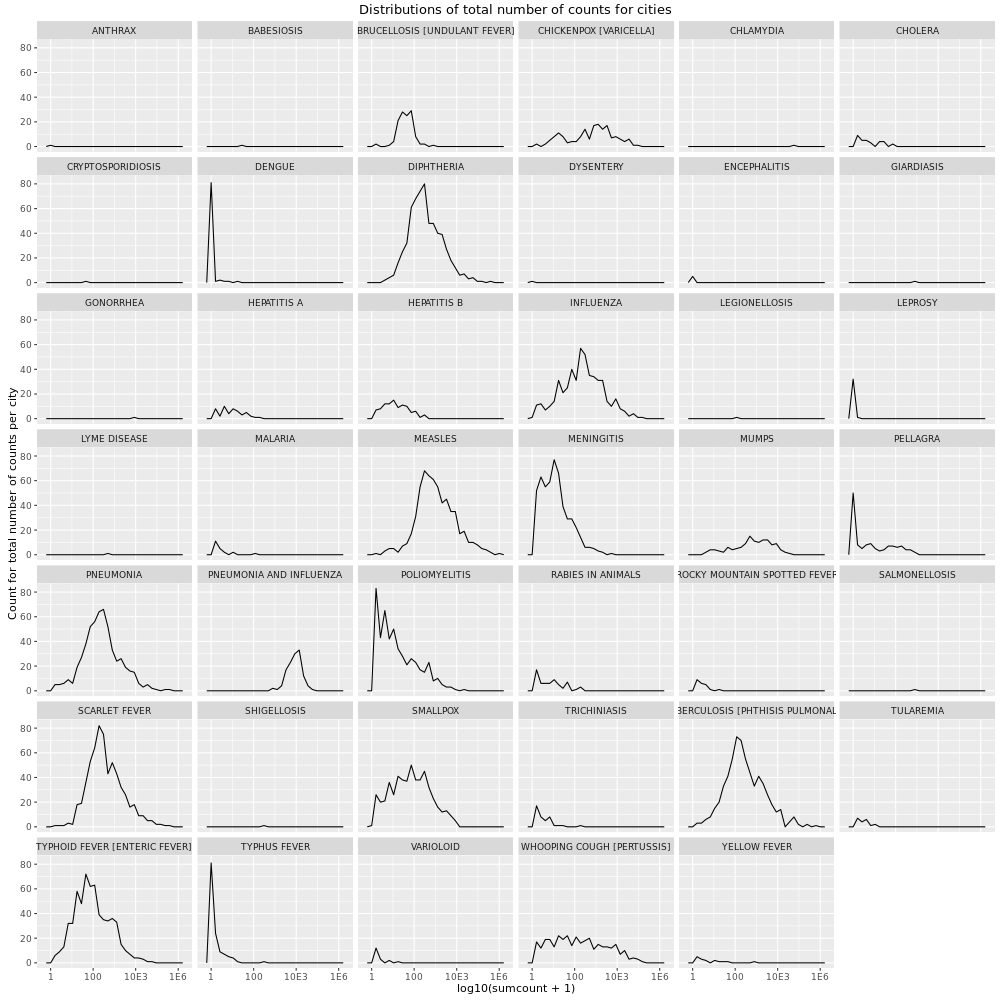

In [47]:
%%R -w 1000 -h 1000

dataf_sumcount <- casecount_tbl %>%
    dplyr::inner_join(disease_tbl, by=c("disease_id"="id")) %>%
    dplyr::group_by(location_id, disease_id, name) %>%
    dplyr::summarize(sumcount=sum(count)) %>%
    dplyr::arrange( desc(sumcount)) %>%
    dplyr::ungroup() %>%
    dplyr::inner_join(location_tbl, by=c("location_id"="id")) %>%
    dplyr::filter(!is.na(city)) %>%
    collect()

p <- ggplot(dataf_sumcount) +
    geom_freqpoly(aes(x=log10(sumcount+1))) +
    scale_x_continuous(breaks=c(0,2,4,6), label=c("1","100","10E3", "1E6")) +
    facet_wrap(~name, ncol=6) +
    scale_y_continuous("Count for total number of counts per city") +
    ggtitle("Distributions of total number of counts for cities")
print(p)

We pick `DIPHTERIA`

## Diphteria

In [12]:
%%R

disease <- "DIPHTHERIA"
dataf_plot <- build_dataf(disease)

The R code for the figure is slightly modified in order to match the range of years displayed to the one we have data for. We observe:
- Two possible main patterns, `CA-IL-NY-PA` and `NC-TX`
- `CA-IL-NY-PA` showing a dip durin the summer months before 1933-1935, and a near eradication throughout the years after 1935
- `NC-TX` showing a presence of diptheria mostly during Sep.-Jan. that lasted until about 1948

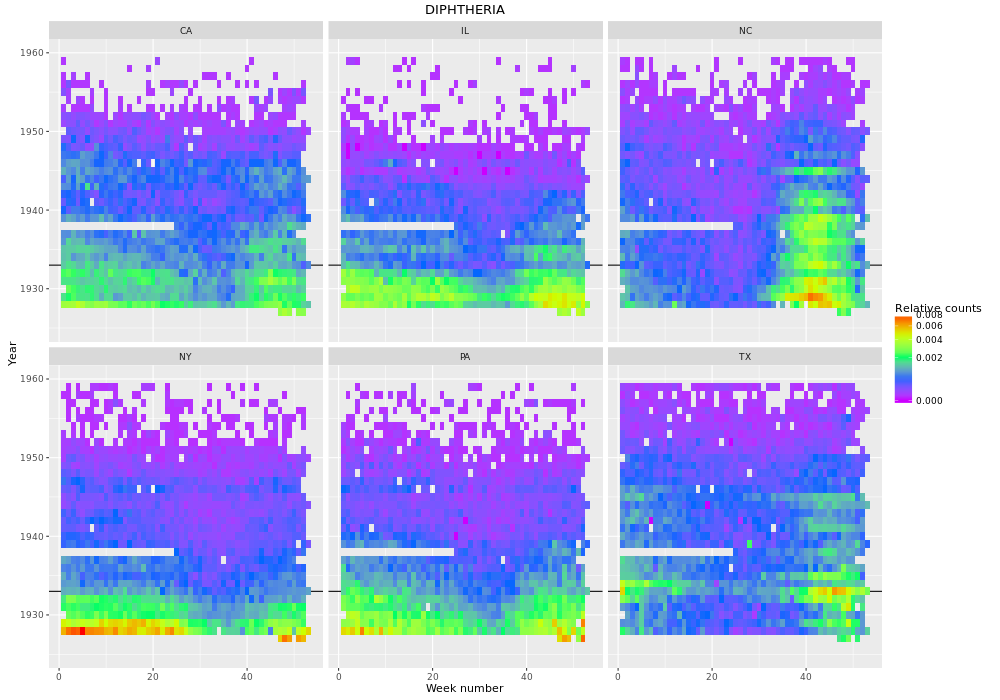

In [13]:
%%R -w 1000 -h 700
p <- ggplot(dataf_plot %>%
            dplyr::filter(is.na(city))) +
       geom_hline(yintercept=1933) +
       geom_tile(aes(x=weeknum, y=as.integer(year), fill=count/sumcount)) +
       scale_fill_gradientn("Relative counts",
                            trans="sqrt", colors=rev(rainbow(5))) +
       scale_x_continuous("Week number") +
       scale_y_continuous("Year", limits=c(1925, 1960)) +
       facet_wrap(~state) +
       ggtitle(disease)
print(p)

The two main groups of patterns can still be observed when looking at a larger number of states, which is now trivially achieved thanks to the parameter `"topn"` in our functions. We can also observe that the total number of cases differs a lot between states.

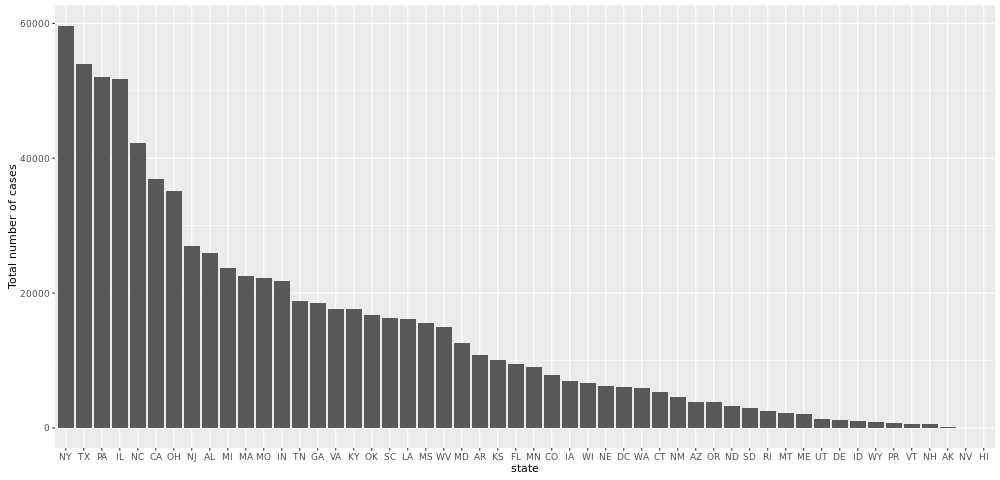

In [14]:
%%R -w 1000

most_cases <- get_locations_with_most_cases(disease, topn=52, state_level=TRUE)$top_locations

p <- ggplot(most_cases) +
       geom_bar(aes(y=sumcount, x=factor(state, levels=as.character(most_cases$state))),
                stat="identity") +
       scale_x_discrete("state") +
       scale_y_continuous("Total number of cases")
print(p)

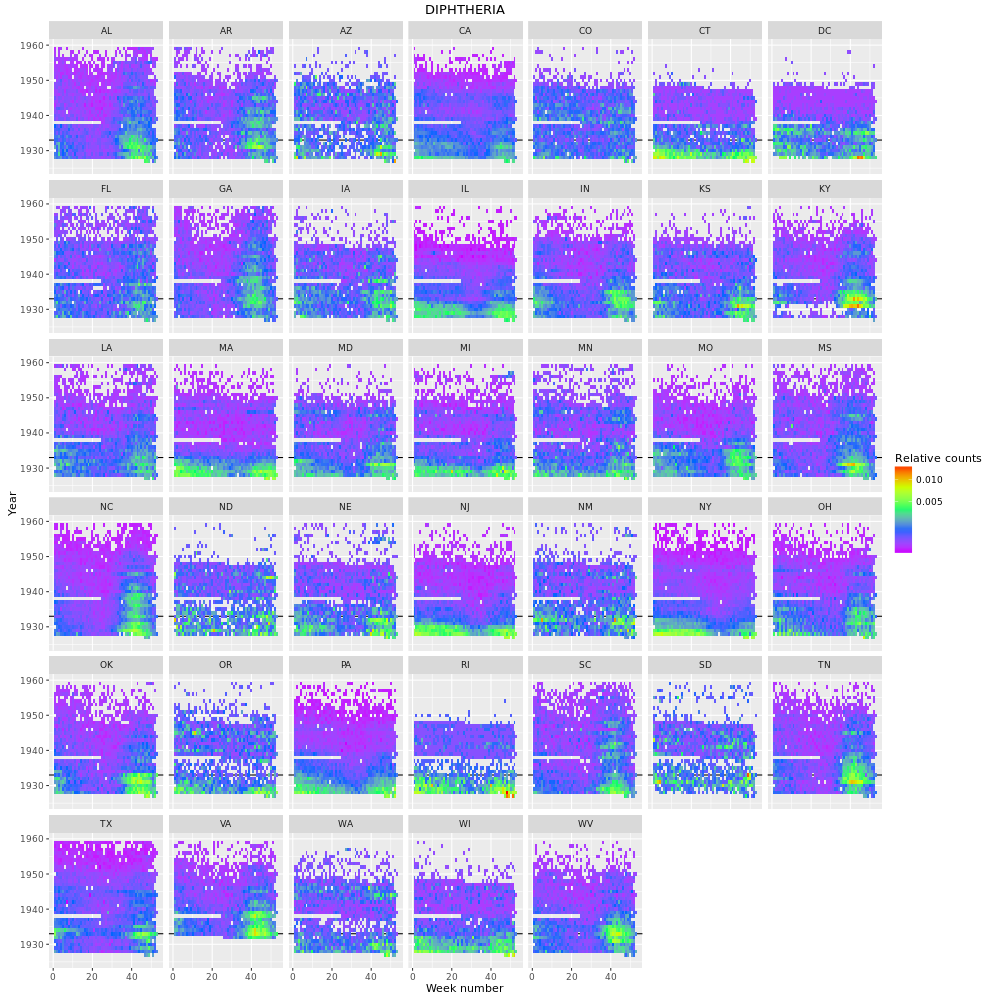

In [15]:
%%R -w 1000 -h 1000

dataf_plot <- build_dataf(disease, topn=40)
p <- ggplot(dataf_plot %>%
            dplyr::filter(is.na(city))) +
       geom_hline(yintercept=1928) +
       geom_tile(aes(x=weeknum, y=as.integer(year), fill=(count+1)/(sumcount+1))) +
       scale_fill_gradientn("Relative counts",
                            trans="sqrt", colors=rev(rainbow(5))) +
       scale_x_continuous("Week number") +
       scale_y_continuous("Year", limits=c(1925, 1960)) +
       facet_wrap(~state) +
       ggtitle(disease)
print(p)

A crude way to group the states is to flatten the array year-times-week-number and use the resulting vector for each state to mesure a distance between them (the states). This is not unlike what is done when preparing vectors from images for eigenfaces, but we are solely after grouping the state-level pattern. Hierarchical cluster is an easy way to look this:

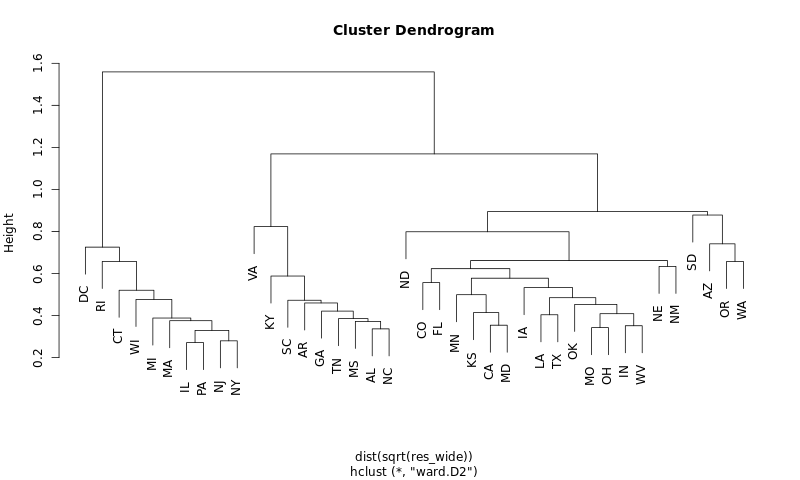

In [16]:
%%R -w 800

by_state <- dataf_plot %>%
            dplyr::filter(is.na(city), (as.integer(year) >= 1925) & (as.integer(year) <= 1960)) %>%
            dplyr::group_by(state)
vmat <- function(d) {
    m <- matrix(0, nrow=1960-1925, ncol=54)
    idx <- as.matrix(d %>% dplyr::mutate(x=as.integer(year)-1925, y=weeknum+1) %>% select(x, y))
    m[idx] <- d$count/d$sumcount
    data.frame(value=c(m),i=seq(along=c(m)))
}
res_long <- by_state %>%
            dplyr::do(vmat(.))
res_wide <- reshape2::acast(res_long, state~i, value.var="value")

hc <- hclust(dist(sqrt(res_wide)), method="ward.D2")
plot(hc)

The dendrogram for the hierarchical clustering above is showing 3-4 main groups, with VA a litte peculiar (a quick visual inspection is showing older data is not available for VA compared to other states). We set an height threshold for clusters at 0.05. The resulting groups can be plotted with the dendrogram: 

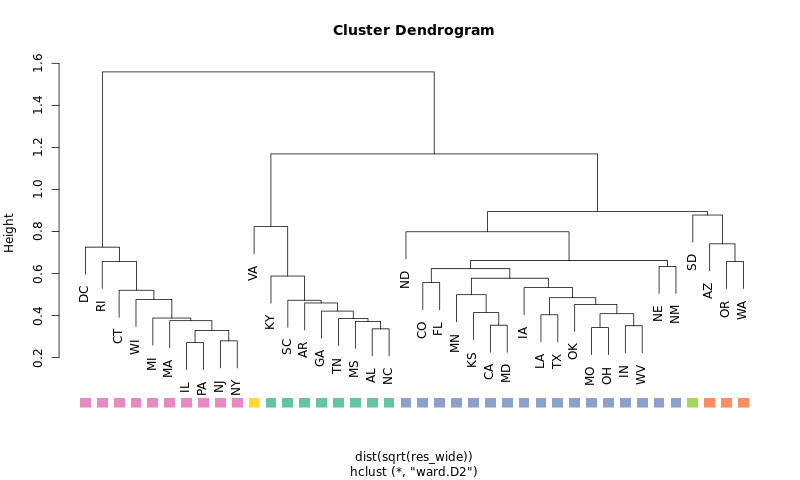

In [17]:
%%R -w 800

ct <- cutree(hc, h=0.8)
dataf_ct <- data.frame(state=names(ct),
                       grp=as.factor(paste("grp:", unname(ct))))
plot(hc, hang=0.1)
colors <- RColorBrewer::brewer.pal(length(unique(ct)), "Set2")
points(seq(along=ct), rep(-0.02, length(ct)), col = colors[ct[hc$order]], pch=15, cex=2)

Our 2D profiles can plotted again, this time ordered by groups:

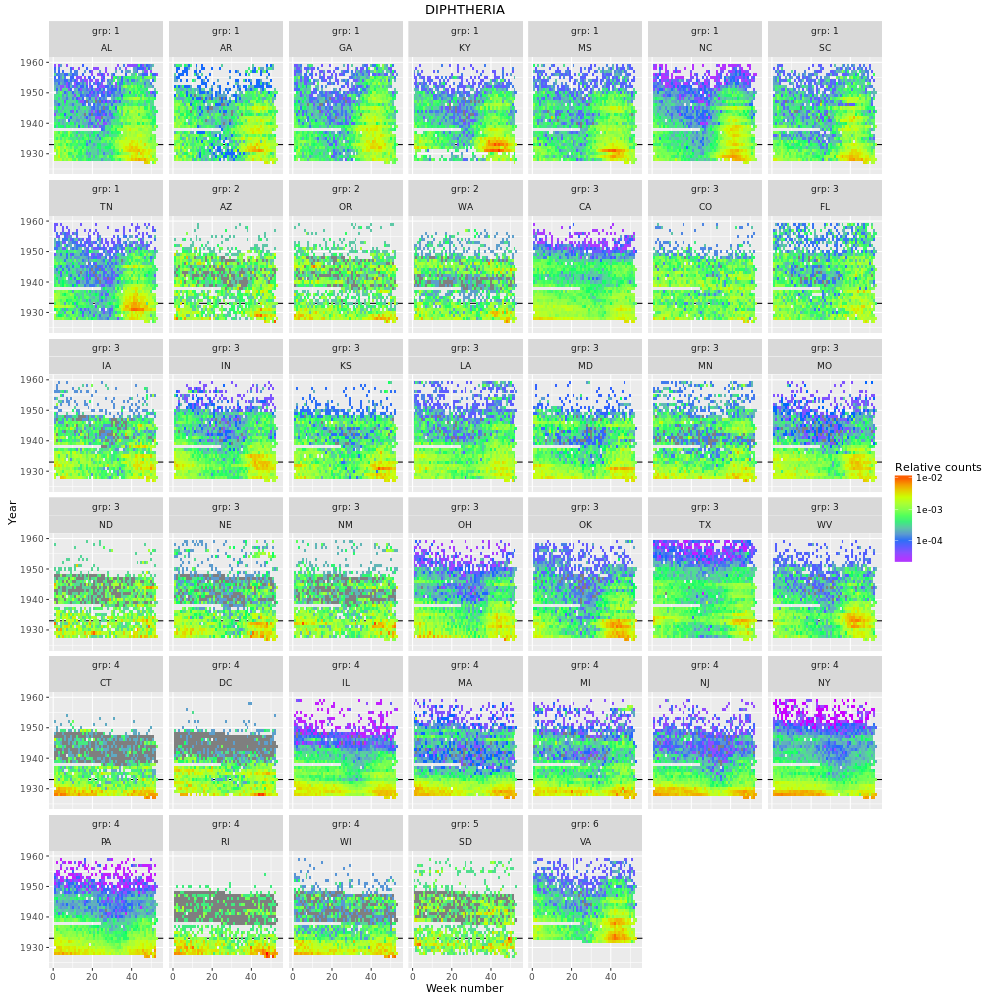

In [18]:
%%R -w 1000 -h 1000

p <- ggplot(dataf_plot %>%
            dplyr::filter(is.na(city)) %>%
            inner_join(dataf_ct, by="state")) +
       geom_hline(yintercept=1928) +
       geom_tile(aes(x=weeknum, y=as.integer(year), fill=count/sumcount)) +
       scale_fill_gradientn("Relative counts",
                            trans="log10", colors=rev(rainbow(5))) +
       scale_x_continuous("Week number") +
       scale_y_continuous("Year", limits=c(1925, 1960)) +
       facet_wrap(~grp+state) +
       ggtitle(disease)
print(p)


We can also superimpose the 2D profiles within our four groups. The group 3 (leftmost group on the dendrogram above) is the most singular while groups 1,2, and 4 are relatively closer:

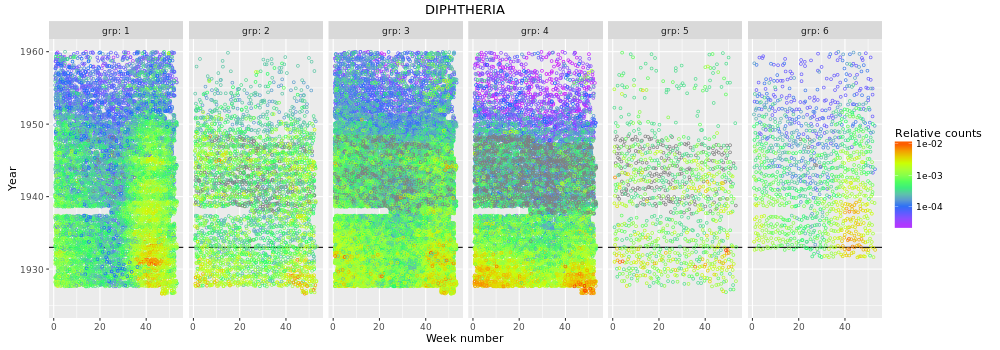

In [19]:
%%R -w 1000 -h 350

p <- ggplot(dataf_plot %>%
            dplyr::filter(is.na(city)) %>%
            inner_join(dataf_ct, by="state")) +
       geom_hline(yintercept=1928) +
       geom_jitter(aes(x=weeknum, y=as.integer(year), color=count/sumcount), shape=1, size=1) +
       scale_color_gradientn("Relative counts",
                            trans="log10", colors=paste0(rev(rainbow(5)))) +
       scale_x_continuous("Week number") +
       scale_y_continuous("Year", limits=c(1925, 1960)) +
       facet_wrap(~grp, nrow=1) +
       ggtitle(disease)
print(p)

When placing the 4 groups on a map, there is an intriguing geographical proximity of the states falling into the same groups. For example our group 3 is located in the North-Eastern part of the US. The data are state-level aggregates and while is it tentalizing to make initial hypotheses and interpretation one should keep in mind the possibly of bias (modifiable areal unit problem) or non-significant spatial patterns.

We can also observe that, unfortunately, data is apparently not available for a number of states. 

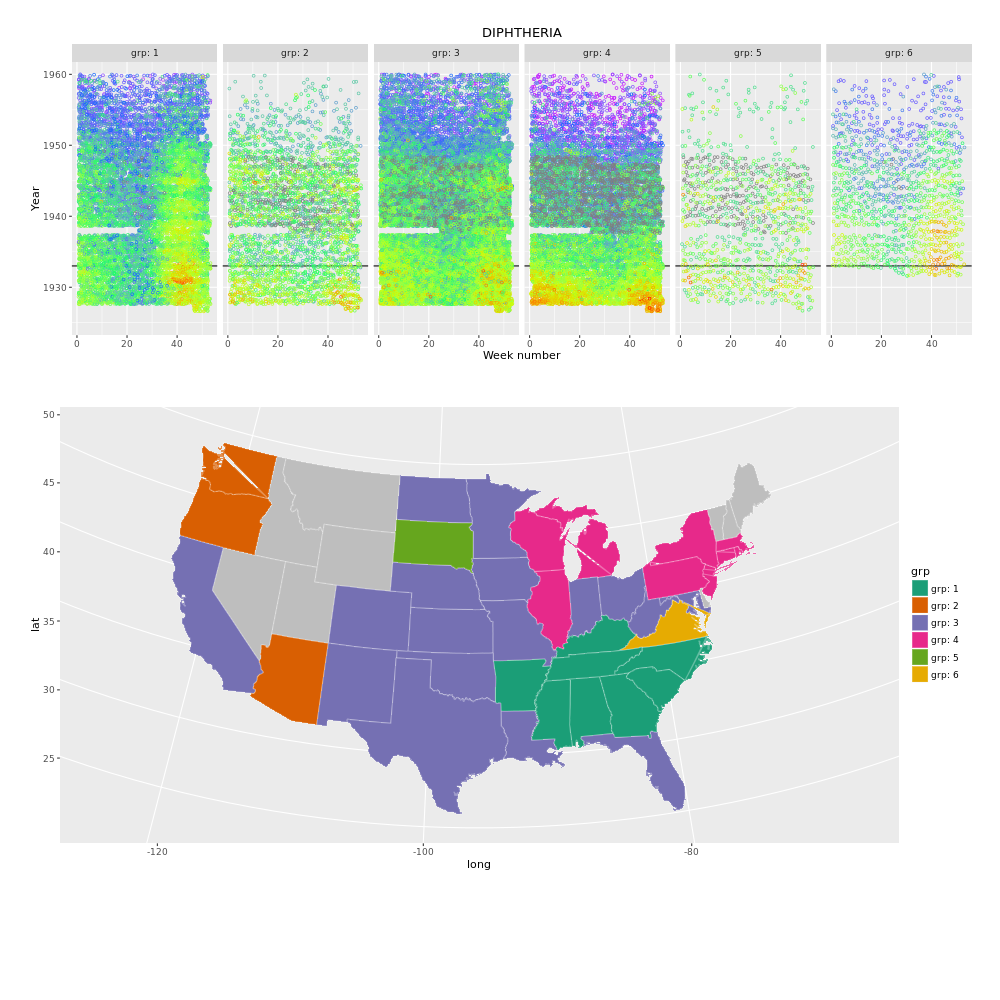

In [20]:
%%R -w 1000 -h 1000

grid::grid.newpage()
grid::pushViewport(grid::viewport(layout = grid::grid.layout(3, 1)))
print(p + theme(legend.position="none",
                plot.margin=unit(c(1,1,-1,1), "cm")), 
      vp = grid::viewport(layout.pos.row = 1,
                          layout.pos.col = 1))

state_abb <- data.frame(state=I(state.abb),
                        state_name=I(state.name),
                        region=I(tolower(state.name)))

suppressMessages(library(maps))

states <- ggplot2::map_data('state')

states_map <- base::merge(states, state_abb, sort=FALSE, by="region")
dataf_plot_map <- base::merge(states_map, dataf_ct, all.x=TRUE, sort=FALSE, by="state")
dataf_plot_map <- dplyr::arrange(dataf_plot_map, order)

p <- (ggplot(dataf_plot_map) +
      geom_polygon(aes(x=long, y=lat, fill=grp, group=state), color="#FFFFFF50") +
      scale_fill_brewer(type="qual", palette=2, na.value="grey") +
      coord_map("albers",  at0 = 45.5, lat1 = 29.5))

print(p + theme(plot.margin=unit(c(-1,1,1,1), "cm")),
      vp = grid::viewport(layout.pos.row = 2:3,
                             layout.pos.col = 1))


To explore the data further, we can look at the city-level. For this we install the R package `ggmap`.

In [21]:
%%R
suppressMessages(install.packages("ggmap", repos="http://cran.r-project.org", quiet=TRUE))


In [22]:
%%R 

dataf_cities <- mutate(get_locations_with_most_cases(disease, topn=150, state_level=FALSE)$top_locations, 
                       query=paste(city, state, sep=", ")) %>% collect()
unique_pos <- lapply(seq(1, 150, by=30),
                     function(x) suppressMessages(ggmap::geocode(dataf_cities$query[x:min(x+29, nrow(dataf_cities))])))
unique_pos <- bind_rows(unique_pos)
dataf_citypos <- bind_cols(unique_pos, dataf_cities)

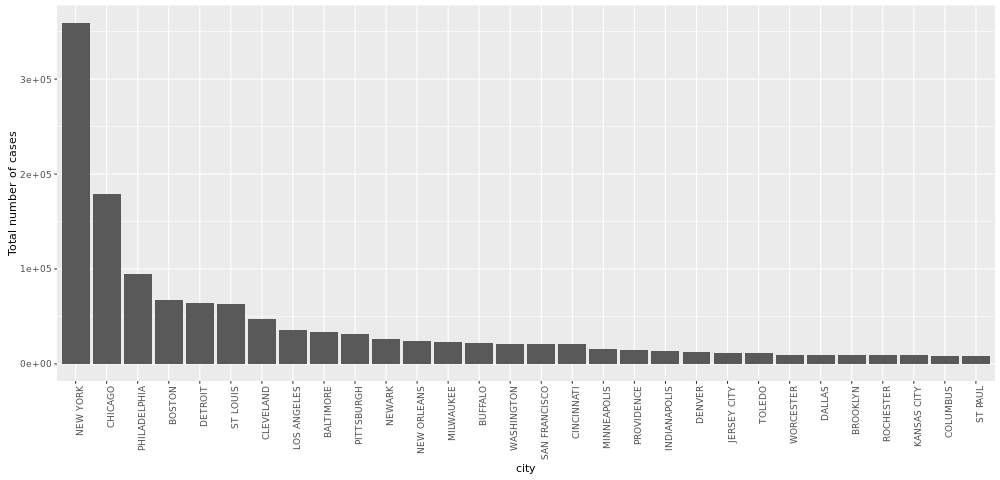

In [23]:
%%R -w 1000

p <- ggplot(head(dataf_cities, 30)) +
       geom_bar(aes(y=sumcount, x=factor(city, levels=as.character(city))),
                stat="identity") +
       scale_x_discrete("city") +
       scale_y_continuous("Total number of cases") +
       theme(axis.text.x = element_text(angle = 90, hjust = 1))
print(p)

In [24]:
%%R
dataf_plot_map <- dplyr::inner_join(dataf_cities, dataf_citypos,
                                    by=c("city", "state", "sumcount", "disease_id", "query"), copy=TRUE)

In [25]:
%%R
dataf_plot <- build_dataf(disease, topn=150, state_level=FALSE)

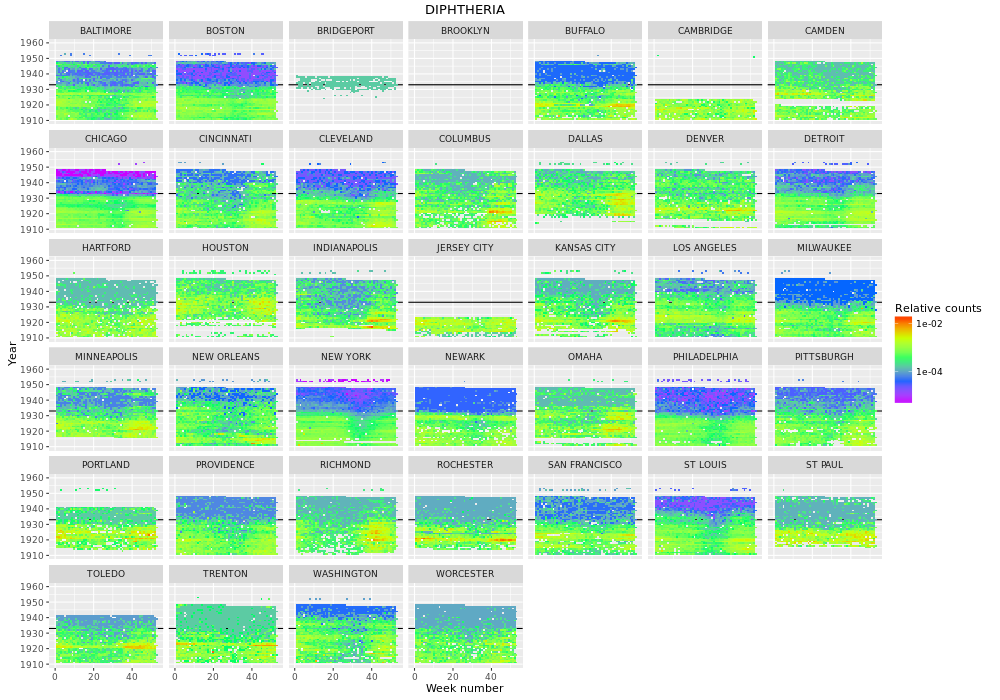

In [26]:
%%R -w 1000 -h 700
p <- ggplot(dataf_plot) +
       geom_hline(yintercept=1928) +
       geom_tile(aes(x=weeknum, y=as.integer(year), fill=(count+1)/(sumcount+1))) +
       scale_fill_gradientn("Relative counts",
                            trans="log10", colors=rev(rainbow(5))) +
       scale_x_continuous("Week number") +
       scale_y_continuous("Year", limits=c(1910, 1960)) +
       facet_wrap(~city) +
       ggtitle(disease)
print(p)

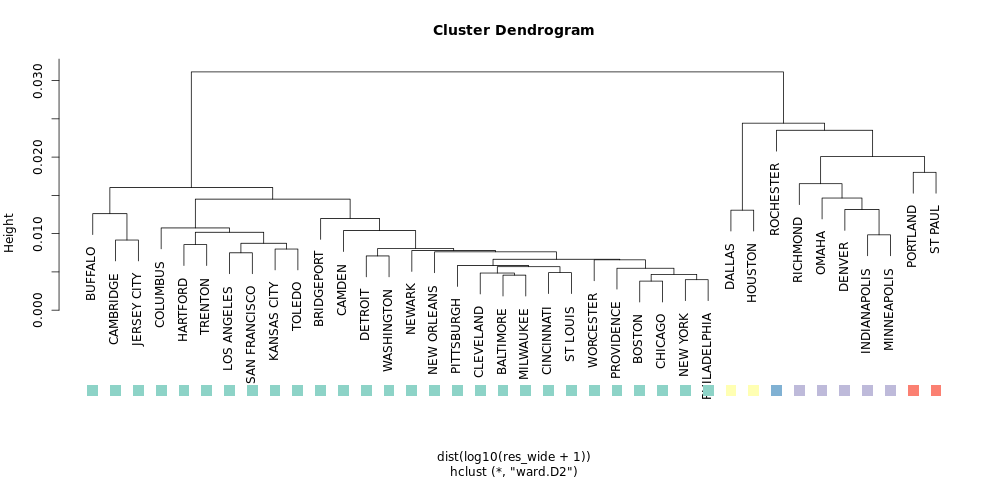

In [27]:
%%R -w 1000

by_loc <- dataf_plot %>%
            dplyr::filter(as.integer(year) >= 1910, as.integer(year) <= 1960) %>%
            dplyr::group_by(city)
vmat <- function(d) {
    m <- matrix(0, nrow=1960-1910, ncol=54)
    idx <- as.matrix(d %>% dplyr::mutate(x=as.integer(year)-1910, y=weeknum+1) %>% select(x, y))
    m[idx] <- (d$count+1)/(d$sumcount+1)
    data.frame(value=c(m),i=seq(along=c(m)))
}
res_long <- by_loc %>%
            dplyr::do(vmat(.))
res_wide <- reshape2::acast(res_long, city~i, value.var="value")

hc <- hclust(dist(log10(res_wide+1)), method="ward.D2")
ct <- cutree(hc, h=0.02)
dataf_ct <- data.frame(city=names(ct),
                       grp=as.factor(paste("grp:", unname(ct))))
plot(hc, hang=0.1)
colors <- RColorBrewer::brewer.pal(length(unique(ct)), "Set3")
points(seq(along=ct), rep(-0.0105, length(ct)), col = colors[ct[hc$order]], pch=15, cex=2)

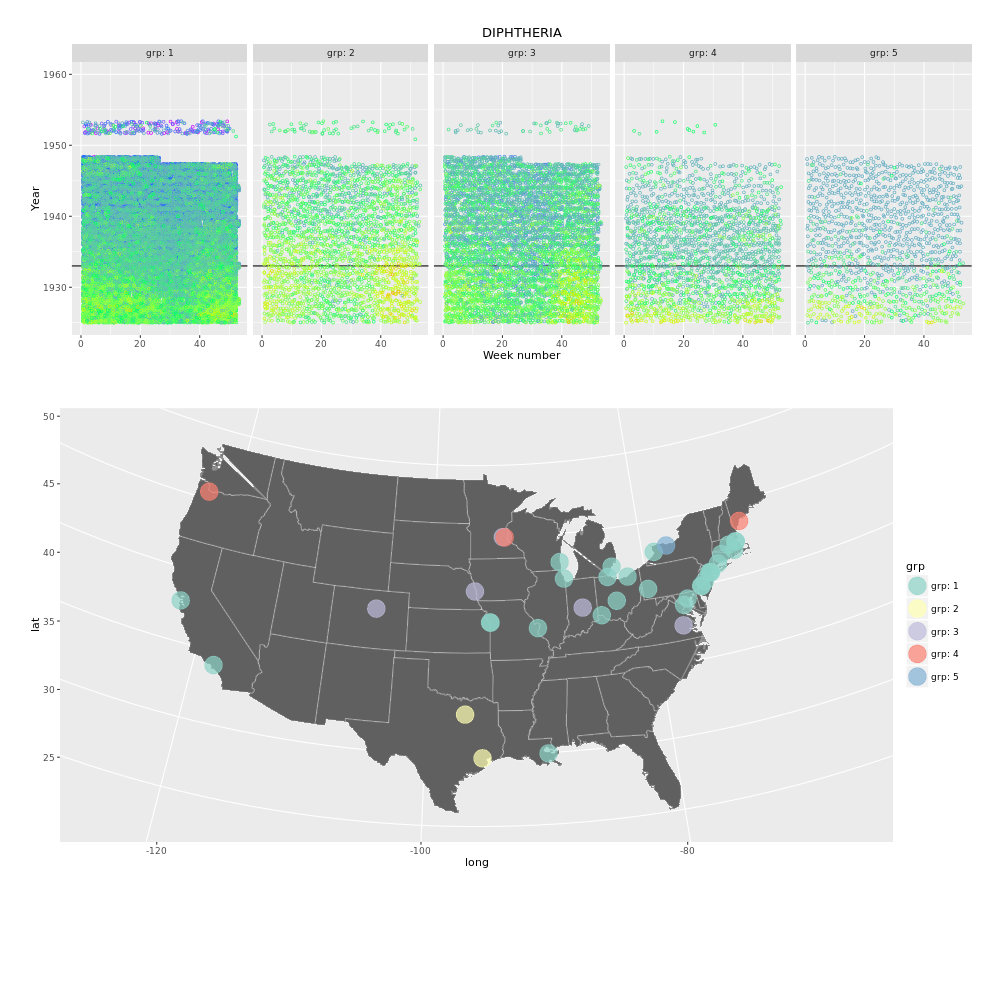

In [28]:
%%R -w 1000 -h 1000

grid::grid.newpage()
grid::pushViewport(grid::viewport(layout = grid::grid.layout(3, 1)))

p <- ggplot(dataf_plot %>%
            inner_join(dataf_ct, by="city")) +
       geom_hline(yintercept=1928) +
       geom_jitter(aes(x=weeknum, y=as.integer(year), color=(count+1)/(sumcount+1)), shape=1, size=1) +
       scale_color_gradientn("Relative counts",
                            trans="log10", colors=paste0(rev(rainbow(5)))) +
       scale_x_continuous("Week number") +
       scale_y_continuous("Year", limits=c(1925, 1960)) +
       facet_wrap(~grp, nrow=1) +
       ggtitle(disease)

print(p + theme(legend.position="none",
                plot.margin=unit(c(1,1,-1,1), "cm")), 
      vp = grid::viewport(layout.pos.row = 1,
                          layout.pos.col = 1))

states <- ggplot2::map_data('state')

states_map <- base::merge(states, state_abb, sort=FALSE, by="region")
dataf_plot_map <- dplyr::arrange(states_map, order)
dataf_plot_cities <- base::merge(dataf_citypos, dataf_ct, by="city")

p <- (ggplot(dataf_plot_map) +
      geom_polygon(aes(x=long, y=lat, group=state), fill="#606060", color="#FFFFFF50") +
      geom_point(aes(x=lon, y=lat, color=grp), alpha=0.7, size=8, data=dataf_plot_cities) +
      scale_color_brewer(type="qual", palette="Set3", na.value="grey") +
      coord_map("albers",  at0 = 45.5, lat1 = 29.5))

print(p + theme(plot.margin=unit(c(-1,1,1,1), "cm")),
      vp = grid::viewport(layout.pos.row = 2:3,
                             layout.pos.col = 1))

# Appendix:

## Unfinished work

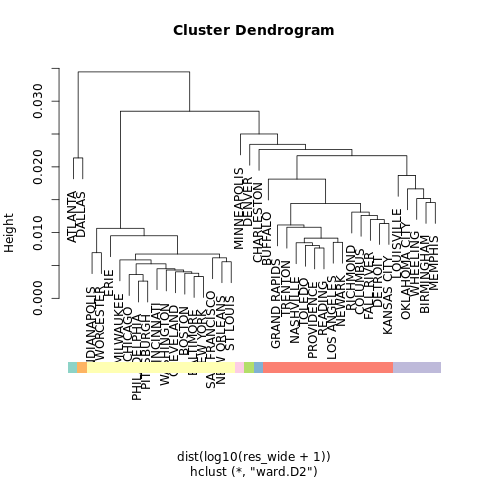

In [42]:
%%R

disease <- "TYPHOID FEVER [ENTERIC FEVER]"
dataf_plot <- build_dataf(disease, topn=150, state_level=FALSE)
by_loc <- dataf_plot %>%
            dplyr::filter(as.integer(year) >= 1910, as.integer(year) <= 1960) %>%
            dplyr::group_by(city)
vmat <- function(d) {
    m <- matrix(0, nrow=1960-1910, ncol=54)
    idx <- as.matrix(d %>% dplyr::mutate(x=as.integer(year)-1910, y=weeknum+1) %>% select(x, y))
    m[idx] <- (d$count+1)/(d$sumcount+1)
    data.frame(value=c(m),i=seq(along=c(m)))
}
res_long <- by_loc %>%
            dplyr::do(vmat(.))
res_wide <- reshape2::acast(res_long, city~i, value.var="value")

hc <- hclust(dist(log10(res_wide+1)), method="ward.D2")
ct <- cutree(hc, h=0.02)
dataf_ct <- data.frame(city=names(ct),
                       grp=as.factor(paste("grp:", unname(ct))))
plot(hc, hang=0.1)
colors <- RColorBrewer::brewer.pal(length(unique(ct)), "Set3")
points(seq(along=ct), rep(-0.011, length(ct)), col = colors[ct[hc$order]], pch=15, cex=2)

In [43]:
%%R

dataf_cities <- mutate(get_locations_with_most_cases(disease, topn=150, state_level=FALSE)$top_locations, 
                       query=paste(city, state, sep=", ")) %>% collect()
unique_pos <- lapply(seq(1, 150, by=30),
                     function(x) suppressMessages(ggmap::geocode(dataf_cities$query[x:min(x+29, nrow(dataf_cities))])))
unique_pos <- bind_rows(unique_pos)
dataf_citypos <- bind_cols(unique_pos, dataf_cities)

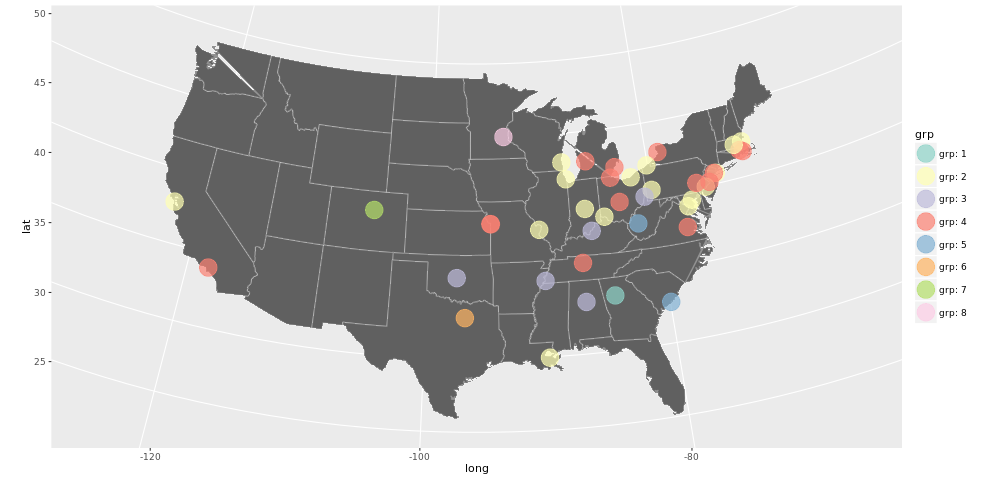

In [46]:
%%R -w 1000

states <- ggplot2::map_data('state')

states_map <- base::merge(states, state_abb, sort=FALSE, by="region")
dataf_plot_map <- dplyr::arrange(states_map, order)
dataf_plot_cities <- base::merge(dataf_citypos, dataf_ct, by="city")

p <- (ggplot(dataf_plot_map) +
      geom_polygon(aes(x=long, y=lat, group=state), fill="#606060", color="#FFFFFF50") +
      geom_point(aes(x=lon, y=lat, color=grp), alpha=0.7, size=8, data=dataf_plot_cities) +
      scale_color_brewer(type="qual", palette="Set3", na.value="grey") +
      coord_map("albers",  at0 = 45.5, lat1 = 29.5))
print(p)